In [1]:
import cv2
import torch
import numpy as np
import imp
from google.colab.patches import cv2_imshow
from PIL import Image
import warnings
warnings.simplefilter("ignore")

In [2]:
def load_pytorch_model(model_path):
    model = torch.load(model_path)
    return model

def pytorch_inference(model, img_arr):
    if torch.cuda.is_available():
        dev = 'cuda:0'
    else:
        dev = 'cpu'
    device = torch.device(dev)
    model.to(device)
    input_tensor = torch.tensor(img_arr).float().to(device)
    y_bboxes, y_scores, = model.forward(input_tensor)
    return y_bboxes.detach().cpu().numpy(), y_scores.detach().cpu().numpy()

In [3]:
def decode_bbox(anchors, raw_outputs, variances=[0.1, 0.1, 0.2, 0.2]):
    anchor_centers_x = (anchors[:, :, 0:1] + anchors[:, :, 2:3]) / 2
    anchor_centers_y = (anchors[:, :, 1:2] + anchors[:, :, 3:]) / 2
    anchors_w = anchors[:, :, 2:3] - anchors[:, :, 0:1]
    anchors_h = anchors[:, :, 3:] - anchors[:, :, 1:2]
    raw_outputs_rescale = raw_outputs * np.array(variances)
    predict_center_x = raw_outputs_rescale[:, :, 0:1] * anchors_w + anchor_centers_x
    predict_center_y = raw_outputs_rescale[:, :, 1:2] * anchors_h + anchor_centers_y
    predict_w = np.exp(raw_outputs_rescale[:, :, 2:3]) * anchors_w
    predict_h = np.exp(raw_outputs_rescale[:, :, 3:]) * anchors_h
    predict_xmin = predict_center_x - predict_w / 2
    predict_ymin = predict_center_y - predict_h / 2
    predict_xmax = predict_center_x + predict_w / 2
    predict_ymax = predict_center_y + predict_h / 2
    predict_bbox = np.concatenate([predict_xmin, predict_ymin, predict_xmax, predict_ymax], axis=-1)
    return predict_bbox

In [4]:
def generate_anchors(feature_map_sizes, anchor_sizes, anchor_ratios, offset=0.5):
    anchor_bboxes = []
    for idx, feature_size in enumerate(feature_map_sizes):
        cx = (np.linspace(0, feature_size[0] - 1, feature_size[0]) + 0.5) / feature_size[0]
        cy = (np.linspace(0, feature_size[1] - 1, feature_size[1]) + 0.5) / feature_size[1]
        cx_grid, cy_grid = np.meshgrid(cx, cy)
        cx_grid_expend = np.expand_dims(cx_grid, axis=-1)
        cy_grid_expend = np.expand_dims(cy_grid, axis=-1)
        center = np.concatenate((cx_grid_expend, cy_grid_expend), axis=-1)

        num_anchors = len(anchor_sizes[idx]) +  len(anchor_ratios[idx]) - 1
        center_tiled = np.tile(center, (1, 1, 2* num_anchors))
        anchor_width_heights = []

        for scale in anchor_sizes[idx]:
            ratio = anchor_ratios[idx][0] # select the first ratio
            width = scale * np.sqrt(ratio)
            height = scale / np.sqrt(ratio)
            anchor_width_heights.extend([-width / 2.0, -height / 2.0, width / 2.0, height / 2.0])

        for ratio in anchor_ratios[idx][1:]:
            s1 = anchor_sizes[idx][0] # select the first scale
            width = s1 * np.sqrt(ratio)
            height = s1 / np.sqrt(ratio)
            anchor_width_heights.extend([-width / 2.0, -height / 2.0, width / 2.0, height / 2.0])

        bbox_coords = center_tiled + np.array(anchor_width_heights)
        bbox_coords_reshape = bbox_coords.reshape((-1, 4))
        anchor_bboxes.append(bbox_coords_reshape)
    anchor_bboxes = np.concatenate(anchor_bboxes, axis=0)
    return anchor_bboxes

In [5]:
def single_class_non_max_suppression(bboxes, confidences, conf_thresh=0.2, iou_thresh=0.5, keep_top_k=-1):
    if len(bboxes) == 0: return []

    conf_keep_idx = np.where(confidences > conf_thresh)[0]

    bboxes = bboxes[conf_keep_idx]
    confidences = confidences[conf_keep_idx]

    pick = []
    xmin = bboxes[:, 0]
    ymin = bboxes[:, 1]
    xmax = bboxes[:, 2]
    ymax = bboxes[:, 3]

    area = (xmax - xmin + 1e-3) * (ymax - ymin + 1e-3)
    idxs = np.argsort(confidences)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # keep top k
        if keep_top_k != -1:
            if len(pick) >= keep_top_k:
                break

        overlap_xmin = np.maximum(xmin[i], xmin[idxs[:last]])
        overlap_ymin = np.maximum(ymin[i], ymin[idxs[:last]])
        overlap_xmax = np.minimum(xmax[i], xmax[idxs[:last]])
        overlap_ymax = np.minimum(ymax[i], ymax[idxs[:last]])
        overlap_w = np.maximum(0, overlap_xmax - overlap_xmin)
        overlap_h = np.maximum(0, overlap_ymax - overlap_ymin)
        overlap_area = overlap_w * overlap_h
        overlap_ratio = overlap_area / (area[idxs[:last]] + area[i] - overlap_area)

        need_to_be_deleted_idx = np.concatenate(([last], np.where(overlap_ratio > iou_thresh)[0]))
        idxs = np.delete(idxs, need_to_be_deleted_idx)
    return conf_keep_idx[pick]

In [6]:
MainModel = imp.load_source('KitModel', "MainModel.py")
model = torch.load('/content/model360.pth')


feature_map_sizes = [[45, 45], [23, 23], [12, 12], [6, 6], [4, 4]]
anchor_sizes = [[0.04, 0.056], [0.08, 0.11], [0.16, 0.22], [0.32, 0.45], [0.64, 0.72]]
anchor_ratios = [[1, 0.62, 0.42]] * 5
anchors = generate_anchors(feature_map_sizes, anchor_sizes, anchor_ratios)
anchors_exp = np.expand_dims(anchors, axis=0)
id2class = {0: 'Mask', 1: 'NoMask'}

def inference(image,
              conf_thresh=0.5,
              iou_thresh=0.4,
              target_shape=(160, 160),
              draw_result=True,
              show_result=True
              ):
    output_info = []
    height, width, _ = image.shape
    image_resized = cv2.resize(image, target_shape)
    image_np = image_resized / 255.0  
    image_exp = np.expand_dims(image_np, axis=0)
    image_transposed = image_exp.transpose((0, 3, 1, 2))
    y_bboxes_output, y_cls_output = pytorch_inference(model, image_transposed)
    y_bboxes = decode_bbox(anchors_exp, y_bboxes_output)[0]
    y_cls = y_cls_output[0]
    bbox_max_scores = np.max(y_cls, axis=1)
    bbox_max_score_classes = np.argmax(y_cls, axis=1)
    keep_idxs = single_class_non_max_suppression(y_bboxes,
                                                 bbox_max_scores,
                                                 conf_thresh=conf_thresh,
                                                 iou_thresh=iou_thresh,
                                                 )

    for idx in keep_idxs:
        conf = float(bbox_max_scores[idx])
        class_id = bbox_max_score_classes[idx]
        bbox = y_bboxes[idx]
        xmin = max(0, int(bbox[0] * width))
        ymin = max(0, int(bbox[1] * height))
        xmax = min(int(bbox[2] * width), width)
        ymax = min(int(bbox[3] * height), height)

        if draw_result:
            if class_id == 0:
                color = (0, 255, 0)
            else:
                color = (255, 0, 0)
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
            cv2.putText(image, "%s: %.2f" % (id2class[class_id], conf), (xmin + 2, ymin - 2),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, color)
        output_info.append([class_id, conf, xmin, ymin, xmax, ymax])

    if show_result:
        Image.fromarray(image).show()
    return output_info

In [7]:
img = cv2.imread('/content/face.jpeg')
output = inference(img, show_result=True, target_shape=(360, 360))
output

[[1, 0.988234281539917, 203, 408, 739, 1224]]

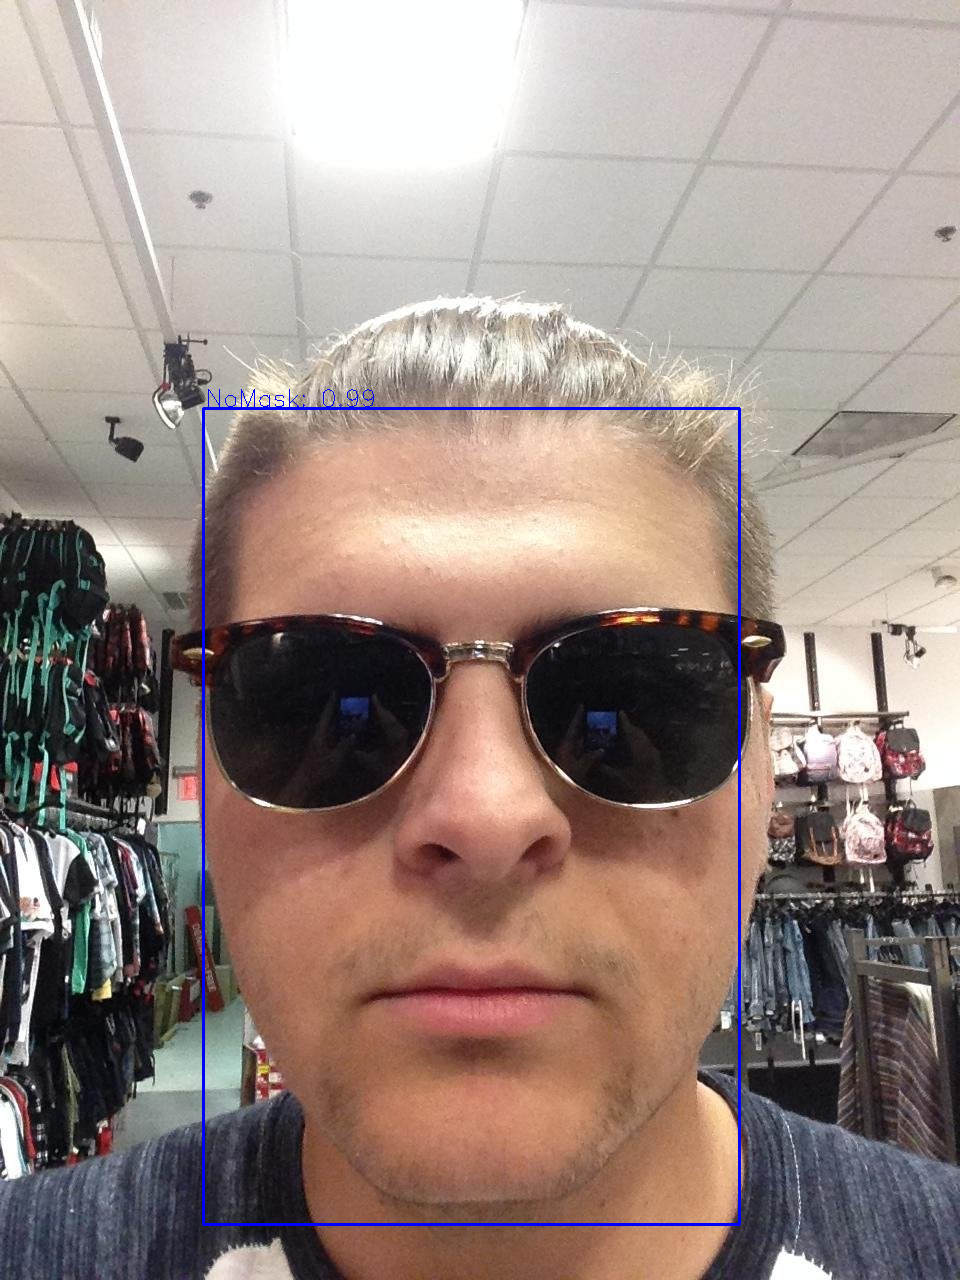

In [8]:
cv2_imshow(img)

In [9]:
img = cv2.imread('/content/mask.jpeg')
output = inference(img, show_result=True, target_shape=(360, 360))
output

[[0, 0.9998477697372437, 369, 381, 1311, 1909]]

In [10]:
cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.